# Math Section

In [2]:
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy'

## Vanilla Kernel Methods

### Simple Example

Text(0.5, 1.0, 'Toy regression dataset')

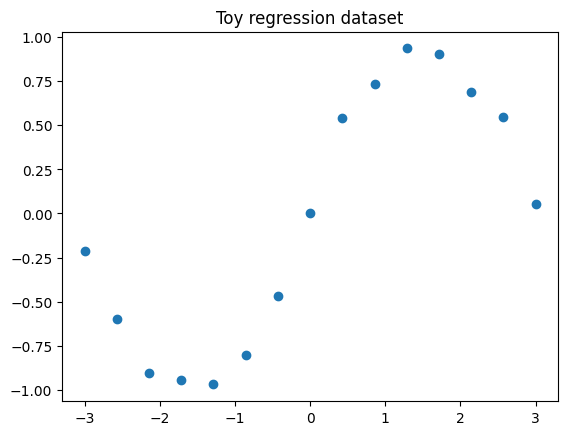

In [ ]:
# Toy dataset
n = 15
X = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.sin(X).ravel() + 0.1*np.random.randn(n)

plt.scatter(X, y)
plt.title("Toy regression dataset")

In [ ]:
def rbf_kernel(X1, X2, sigma=0.6):
    # X1 (N, d)
    # X2 (N, d)
    sq_dist = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2*(X1 @ X2.T)
    return np.exp(-sq_dist/(2*sigma**2))

In [ ]:
Knn = rbf_kernel(X, X)

print("Kernel matrix shape:", Knn.shape)
print(Knn[:4,:4])


Kernel matrix shape: (15, 15)
[[1.         0.77483743 0.36044779 0.1006689 ]
 [0.77483743 1.         0.77483743 0.36044779]
 [0.36044779 0.77483743 1.         0.77483743]
 [0.1006689  0.36044779 0.77483743 1.        ]]


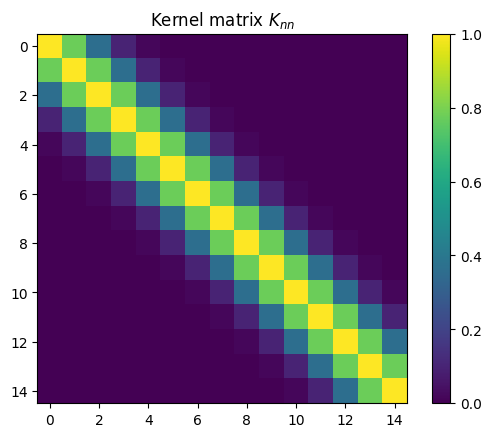

In [ ]:
plt.imshow(Knn)
plt.colorbar()
plt.title("Kernel matrix $K_{nn}$")
plt.show()


In [ ]:
alpha = np.random.randn(n)

x_test = np.linspace(-4,4,200).reshape(-1,1)
K_test = rbf_kernel(x_test, X)

f_pred_random = K_test @ alpha

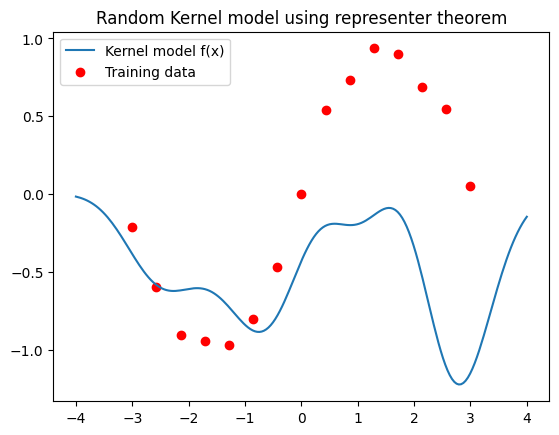

In [ ]:
plt.plot(x_test, f_pred_random, label="Kernel model f(x)")
plt.scatter(X, y, color="red", label="Training data")
plt.legend()
plt.title("Random Kernel model using representer theorem")
plt.show()


In [ ]:
l = 0.01
alpha_sol = np.linalg.solve(Knn+l*n*np.eye(n), y)
alpha_sol

array([ 0.12457074, -0.21937298, -0.47537698, -0.08002912, -0.39721592,
       -0.24962553, -0.16813921, -0.14547157,  0.52190888, -0.06581447,
        0.45146883,  0.35770154, -0.1163485 ,  0.68455576, -0.41702734])

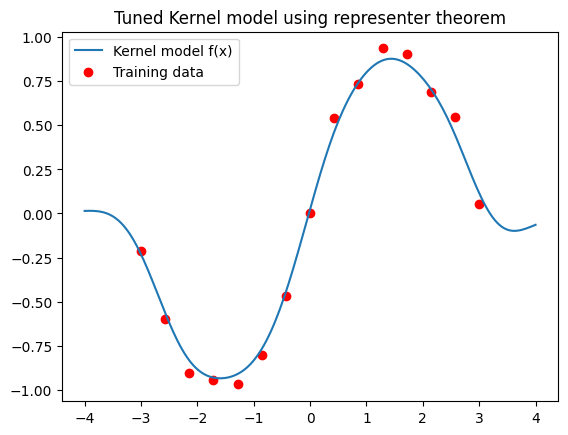

In [ ]:
f_pred = K_test @ alpha_sol
plt.plot(x_test, f_pred, label="Kernel model f(x)")
plt.scatter(X, y, color="red", label="Training data")
plt.legend()
plt.title("Tuned Kernel model using representer theorem")
plt.show()

### Time Benchmarking

In [ ]:
import time
from time import perf_counter as tic
######### Solutions #############
def rbf_kernel(X1, X2, sigma=0.6):
    # X1 (N, d)
    # X2 (N, d)
    sq_dist = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2*(X1 @ X2.T)
    return np.exp(-sq_dist/(2*sigma**2))

def solve_l2_problem(X, y, sigma = 0.1 ,reg = 0.1):
    N,d = X.shape

    # Computer Kernel
    K = rbf_kernel(X,X,sigma=sigma)
    A = K + reg * N * np.eye(N)
    alpha_sol = np.linalg.solve(A,y)

    return alpha_sol


######### Benchmarking ############
def time_benchmark(n_max=1e3, n_points=2):
    # Log-spaced sizes from 10 to n_max
    n_s = np.unique(
        np.logspace(1, np.log10(n_max), n_points).astype(int)
    )
    
    print(f"Benchmarking solve_l2_problem on dataset sizes: {n_s}")
    times = []
    n_s = [int(n) for n in n_s]
    X_benchmark = [np.linspace(-5,5,n).reshape(-1,1) for n in n_s]
    y_benchmark = [np.sin(X_benchmark[i]).ravel() + 0.1*np.random.randn(n) for i,n in enumerate(n_s)]

    times = []

    for i,n in enumerate(n_s):
        print(f"[{i}/{len(n_s)}] Running benchmark for n = {n}")
        t0 = time.time()
        solve_l2_problem(X_benchmark[i], y_benchmark[i])
        times.append((time.time() - t0))

    return times, n_s


def plot_scaling(n_s, times):
    n_s = np.asarray(n_s)
    times = np.asarray(times)

    plt.figure(figsize=(7,5))

    plt.loglog(
        n_s,
        times,
        "o-",
        linewidth=2,
        markersize=6
    )

    plt.xlabel("Dataset size n")
    plt.ylabel("Runtime (ms)")
    plt.title("Kernel Method Scaling")

    plt.grid(True, which="both", linestyle=":", alpha=0.6)

    plt.tight_layout()

Benchmarking solve_l2_problem on dataset sizes: [  10   12   15   19   23   29   36   44   55   68   85  105  130  162
  200  248  308  382  473  586  726  900 1115 1382 1712 2121 2628 3257
 4035 4999]
[0/30] Running benchmark for n = 10
[1/30] Running benchmark for n = 12
[2/30] Running benchmark for n = 15
[3/30] Running benchmark for n = 19
[4/30] Running benchmark for n = 23
[5/30] Running benchmark for n = 29
[6/30] Running benchmark for n = 36
[7/30] Running benchmark for n = 44
[8/30] Running benchmark for n = 55
[9/30] Running benchmark for n = 68
[10/30] Running benchmark for n = 85
[11/30] Running benchmark for n = 105
[12/30] Running benchmark for n = 130
[13/30] Running benchmark for n = 162
[14/30] Running benchmark for n = 200
[15/30] Running benchmark for n = 248
[16/30] Running benchmark for n = 308
[17/30] Running benchmark for n = 382
[18/30] Running benchmark for n = 473
[19/30] Running benchmark for n = 586
[20/30] Running benchmark for n = 726
[21/30] Running bench

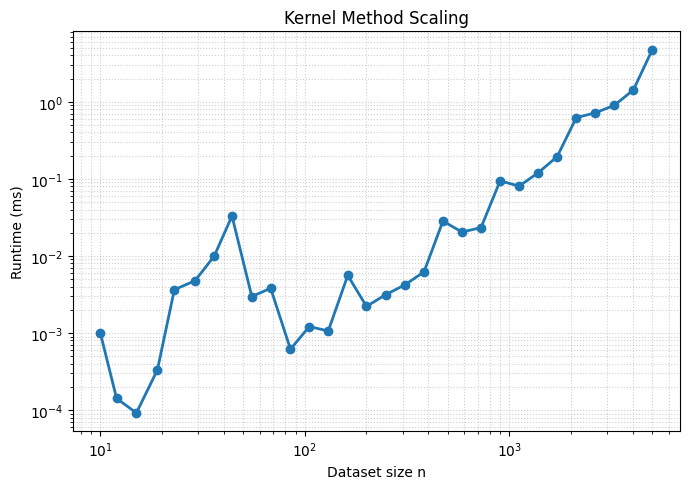

In [ ]:
times, n_s = time_benchmark(n_max=5e3, n_points=30)
plot_scaling(n_s, times)

## Nystrom Method

In [ ]:
def solve_l2_problem_Nystrom(X, y, m=10, sigma=0.1, reg=0.1):
    Xm = X[np.random.choice(len(X), size =m, replace=False)]
    K_nm = rbf_kernel(X, Xm, sigma)     # (n, m)
    K_mm = rbf_kernel(Xm, Xm, sigma)    # (m, m)

    A = K_nm.T @ K_nm + reg * n * K_mm    # (m, m)
    b = K_nm.T @ y                      # (m,)

    beta = np.linalg.solve(A, b)        # (m,)

    return beta, Xm
    

### On a scalled toy dataset

In [ ]:
# Toy dataset
n = 150
X = np.linspace(-10, 10, n).reshape(-1, 1)
y = np.sin(X).ravel() + 0.1*np.random.randn(n)
X_test = np.linspace(-4,4,200).reshape(-1,1)
sigma = 0.1
reg = 0.1
ms=[5,7,10]

### Vanilla  ##
alpha = solve_l2_problem(X, y, sigma=sigma, reg=reg)
K_test = rbf_kernel(X_test, X)
f_test = K_test @ alpha

## Nystrom ##
f_test_ms = []
for m in ms:
    beta, Xm = solve_l2_problem_Nystrom(X,y,m=m, sigma=sigma, reg=reg)
    K_test_m  = rbf_kernel(X_test, Xm)
    f_test_m = K_test_m @ beta

    f_test_ms.append(f_test_m)


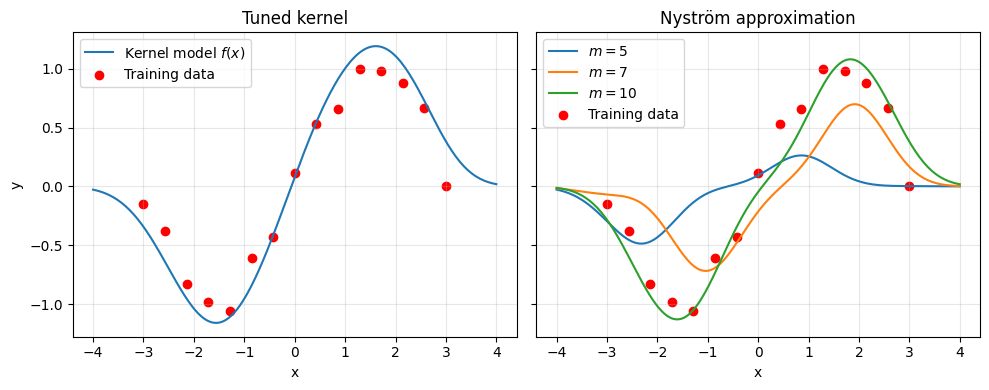

In [ ]:
fig, axs = plt.subplots(
    1, 2,
    figsize=(10, 4),
    sharex=True,
    sharey=True
)

# ----- Left panel -----
axs[0].plot(x_test, f_test, label="Kernel model $f(x)$")
axs[0].scatter(X, y, label="Training data",c="r")
axs[0].set_title("Tuned kernel")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# ----- Right panel -----
for i,m in enumerate(ms):
    axs[1].plot(x_test, f_test_ms[i], label=f"$m={m}$")

axs[1].scatter(X, y, label="Training data", c="r")
axs[1].set_title("Nyström approximation")
axs[1].set_xlabel("x")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
